In [13]:
import pennylane as qml
from pennylane import qchem

# Hartree-Fock state
hf = qml.qchem.hf_state(electrons=2,orbitals=4)

In [14]:
from pennylane import numpy as np

# atomic symbols defining the molecule
symbols = ['H','H']

# list to store energies
energies = []

# set up a loop to change bond length
r_range = np.arange(0.5, 5.0, 0.25)

# keeps track of points in the potential energy surface
pes_point = 0

In [15]:
for r in r_range:
    # Change only the z coordinate of one atom
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])

    # Obtain the qubit Hamiltonian
    H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, method='pyscf')

    # define the device, optimizer and circuit
    dev = qml.device("default.qubit", wires=qubits)
    opt = qml.GradientDescentOptimizer(stepsize=0.4)

    @qml.qnode(dev, interface='autograd')
    def circuit(parameters):
        # Prepare the HF state: |1100>
        qml.BasisState(hf, wires=range(qubits))
        qml.DoubleExcitation(parameters[0], wires=[0, 1, 2, 3])
        qml.SingleExcitation(parameters[1], wires=[0, 2])
        qml.SingleExcitation(parameters[2], wires=[1, 3])

        return qml.expval(H)  # we are interested in minimizing this expectation value

    # initialize the gate parameters
    params = np.zeros(3, requires_grad=True)

    # initialize with converged parameters from previous point
    if pes_point > 0:
        params = params_old

    prev_energy = 0.0
    for n in range(50):
        # perform optimization step
        params, energy = opt.step_and_cost(circuit, params)

        if np.abs(energy - prev_energy) < 1e-6:
            break
        prev_energy = energy

    # store the converged parameters
    params_old = params
    pes_point = pes_point + 1

    energies.append(energy)

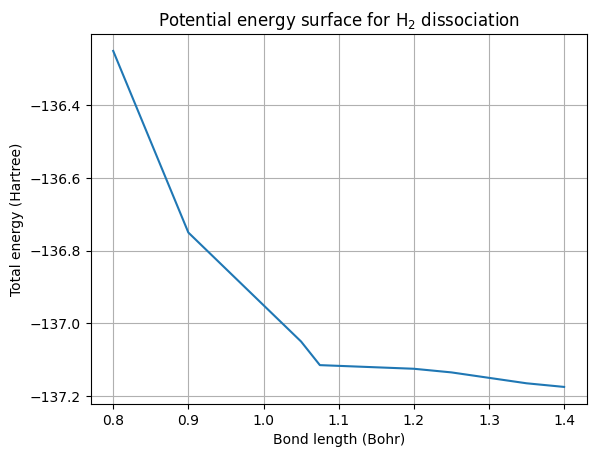

In [16]:
import matplotlib.pyplot as plt

r_range = [0.8,0.9,1.025,1.050,1.075,1.2,1.25,1.3,1.35,1.4]
energies = [-136.25,-136.75,-137,-137.05,-137.115,-137.125,-137.135,-137.150,-137.165,-137.175]
fig, ax = plt.subplots()
ax.plot(r_range, energies)

ax.set(
    xlabel="Bond length (Bohr)",
    ylabel="Total energy (Hartree)",
    title="Potential energy surface for H$_2$ dissociation",
)
ax.grid()
plt.show()